# Intrusion detection using Random Forest model




## Mounting Google Drive

In [2]:
from google.colab import drive
drive.mount("/content/drive")
%cd /content/drive/MyDrive/colab_notebooks/CICIDS2017

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/colab_notebooks/CICIDS2017


In [ ]:
import os
import pandas as pd
import numpy as np

DIR_PATH = "MachineLearningCVE"

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 12)
pd.set_option('display.width', 1000)
pd.options.display.float_format = '{:.2f}'.format

df = pd.read_csv(os.path.join(DIR_PATH, "processed_data.csv"))

# Explore data types and missing values
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2520798 entries, 0 to 2520797
Data columns (total 67 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Destination Port             int64  
 1   Flow Duration                int64  
 2   Total Fwd Packets            int64  
 3   Total Backward Packets       int64  
 4   Total Length of Fwd Packets  int64  
 5   Total Length of Bwd Packets  int64  
 6   Fwd Packet Length Max        int64  
 7   Fwd Packet Length Min        int64  
 8   Fwd Packet Length Mean       float64
 9   Fwd Packet Length Std        float64
 10  Bwd Packet Length Max        int64  
 11  Bwd Packet Length Min        int64  
 12  Bwd Packet Length Mean       float64
 13  Bwd Packet Length Std        float64
 14  Flow Bytes/s                 float64
 15  Flow Packets/s               float64
 16  Flow IAT Mean                float64
 17  Flow IAT Std                 float64
 18  Flow IAT Max                 int64  
 19  


## Balancing the dataset by applying down sampling


425741


(851482, 67)

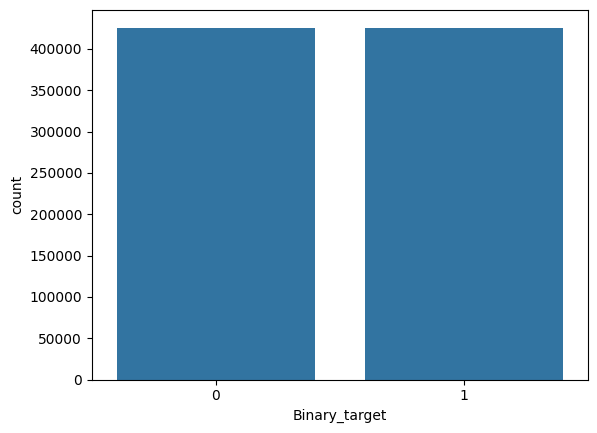

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

size=len(df.loc[df.Binary_target==0])
print(size)
# downsample df.Binary_target==1 to the size of df.Binary_target==0

df1 = df[df['Binary_target'] == 1]
df2 = df[df['Binary_target'] == 0]
df1 = df1.sample(n=len(df2))
bal_df = pd.concat([df1, df2])
# shuffle the dataset
bal_df = bal_df.sample(frac=1).reset_index(drop=True)
sns.countplot(data=bal_df,x='Binary_target')
bal_df.shape

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

y = bal_df['Binary_target'].astype('int')
bal_df.drop(columns=['Label', 'Binary_target'], inplace=True)
X = MinMaxScaler().fit_transform(bal_df)

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)
print(X_train.shape," ",X_test.shape)
print(y_train.shape," ",y_test.shape)


(681185, 65)   (170297, 65)
(681185,)   (170297,)


## Training and evaluating balanced classes after down sampling:

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix

model = RandomForestClassifier(max_depth=50)
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test,y_pred))

# Extract recall and precision
recall = cm[0, 0] / (cm[0, 0] + cm[0, 1])
precision = cm[0, 0] / (cm[0, 0] + cm[1, 0])

# Print recall and precision
print("Recall:", recall)
print("Precision:", precision)

[[85161    56]
 [  113 84967]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85217
           1       1.00      1.00      1.00     85080

    accuracy                           1.00    170297
   macro avg       1.00      1.00      1.00    170297
weighted avg       1.00      1.00      1.00    170297

Recall: 0.9993428541253506
Precision: 0.9986748598634988


## Training and evaluating without data balancing:



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

df = df.sample(frac=1).reset_index(drop=True)
y = df['Binary_target'].astype('int')
df.drop(columns=['Label', 'Binary_target'], inplace=True)
X = MinMaxScaler().fit_transform(df)

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)
print(X_train.shape," ",X_test.shape)
print(y_train.shape," ",y_test.shape)

model = RandomForestClassifier(max_depth=50)
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test,y_pred))

# Extract recall and precision
recall = cm[0, 0] / (cm[0, 0] + cm[0, 1])
precision = cm[0, 0] / (cm[0, 0] + cm[1, 0])

# Print recall and precision
print("Recall:", recall)
print("Precision:", precision)

(2016638, 65)   (504160, 65)
(2016638,)   (504160,)
[[ 84726    289]
 [   265 418880]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85015
           1       1.00      1.00      1.00    419145

    accuracy                           1.00    504160
   macro avg       1.00      1.00      1.00    504160
weighted avg       1.00      1.00      1.00    504160

Recall: 0.9966005998941363
Precision: 0.9968820228024143


## Features Importance

<Axes: xlabel='feature'>

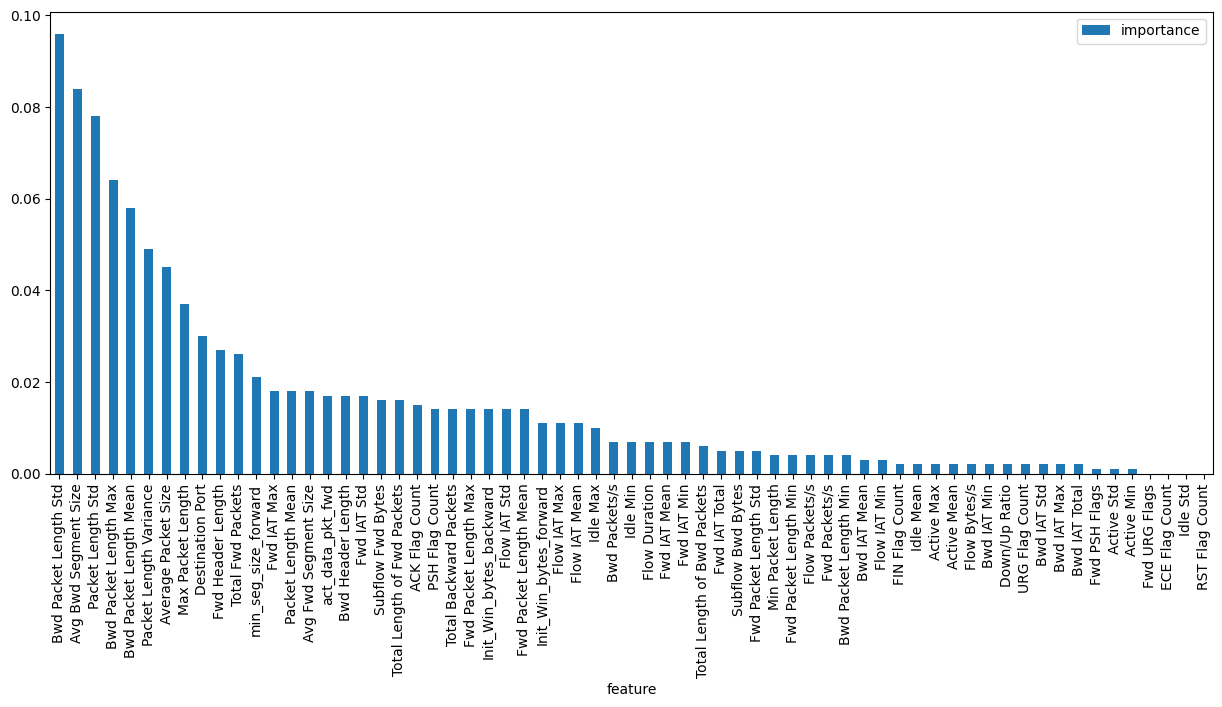

In [ ]:
# extract important features
score = np.round(model.feature_importances_,3)
importances = pd.DataFrame({'feature':df.columns,'importance':score})
importances = importances.sort_values('importance',ascending=False).set_index('feature')

# plot importances
plt.rcParams['figure.figsize'] = (15, 6)
importances.plot.bar()

We see that the most influential parameters are related to the size and length of the packets.

We could see a hint to that when we investigated the correlation between the target and features. The features related to the packet length/size have opposit correlation with the target at ~0.6.